<a href="https://colab.research.google.com/github/MY-Park/Light-LEMONADE/blob/master/Light_LEMONADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Light LEMONADE**

**L**armarckian **E**volutionary algorithm for **M**ulti-**O**bjective **N**eural **A**rchitecture **DE**sign(**LEMONADE**) [1] 알고리즘을 작은 스케일로 재구현한 **Light LEMONADE** 실험 코드입니다.



딥러닝 라이브러리는 tensorflow keras를 사용하였으므로 환경을 세팅해줍니다.

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

tf.__version__

'2.3.0'

학습에 사용할 데이터는 Fashion MNIST[2] 로서 다음과 같이 데이터를 다운 받아줍니다.



In [5]:
import numpy as np
import matplotlib.pyplot as plt

#fasion mnist 데이터셋의 train, test set을 가져옵니다.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# (# train set : 55,000, test set : 5000)
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# 입력 이미지의 크기를 (28, 28) 에서 (28, 28, 1) 로 배열 차원을 변경(reshape)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# 레이블에 원-핫 인코딩 적용
# 원-핫 벡터는 단 하나의 차원에서만 1이고, 나머지 차원에서는 0인 벡터입니다.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# 학습 셋 크기
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# 학습용, 검증용, 테스트용 데이터셋의 개수
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_train shape: (55000, 28, 28, 1) y_train shape: (55000, 10)
55000 train set
5000 validation set
10000 test set


Light LEMONADE에 사용될 Initial Population을 설정해줍니다.

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

pareto_front = set()

#num of filters 4, 8, 16, 32, 64
for i in range(2,7):
  filter = 2 ** i
  inputs1 = tf.keras.layers.Input((28, 28, 1))
  x = tf.keras.layers.Conv2D(filter, (3, 3), activation=None, padding='same')(inputs1)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(10, activation=None)(x)
  x = tf.keras.layers.Activation('softmax')(x)

  model = tf.keras.models.Model(inputs=inputs1, outputs=x)
  #model.summary()
  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  model_path = '/content/drive/My Drive/SBSE/model/model_g0_p'+ str(i) + '.h5'
  model.save(model_path)

  idx=0
  ckt_path = '/content/drive/My Drive/SBSE/weight/model.weights.best.g0_p'+str(i)+'.hdf5'
  
  ## epoch 수를 늘리고 early stopping을 사용하고 싶다면 아래 코드를 활성화 시키고 
  ## model.fit의 파라미터로 callbacks = [es, mc]를 사용해줍니다.
  #es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)

  mc = ModelCheckpoint(filepath=ckt_path, verbose = 0, save_best_only=True)
  train_history = model.fit(x_train,
          y_train,
          batch_size=64,
          epochs=1,
          validation_data=(x_valid, y_valid),
          callbacks=[mc])

  val_loss = min(train_history.history['val_loss'])
  num_param = model.count_params()
  id = 'g0_p'+str(i)
  pareto_front.add((id, num_param, val_loss))

pf_copy = pareto_front
# save pareto front for each generation 
pf_path = '/content/drive/My Drive/SBSE/pareto_front/pf_g0.npy'
list_pf = list(pf_copy)
np.save(pf_path, list_pf)

860/860 [==============================] - 4s 5ms/step - loss: 0.5412 - accuracy: 0.8486 - val_loss: 0.4614 - val_accuracy: 0.8550


### Network Operator

parent network에 operator를 적용하여 child network를 생성하는데, 4가지 operator를 설정해줍니다. 
1. 임의의 ReLU layer 다음에 Convolution(Conv)-BatchNormalization(BatchNorm)-ReLU 블록을 삽입한다. 
2. 임의의 Conv layer 다음에 연속하여 Conv layer를 추가한다. 
3. 임의의 ReLU activation layer output 2개를 골라 skip connection을 추가한다.
4. 임의로 선택한 레이어 한 개를 제거한다.



In [8]:
import random
####################
# network morphism #
####################
# 1. add conv-batchnorm-relu block after relu
def add_block(o_model):

  relu_list = []
  relu_cnt = 0

  filter = 0
  for layer in o_model.layers:
    if isinstance(layer, tf.keras.layers.Activation):
      relu_list.append(layer)
      relu_cnt += 1
    elif isinstance(layer, tf.keras.layers.Conv2D):
      filter = layer.output_shape[3]

  if (relu_cnt-2 < 0):
    new_model = o_model
    return new_model

  rnd = random.randint(0,relu_cnt-2)
  targeted_relu = relu_list[rnd]

  len_layers = len(o_model.layers)
  x = o_model.layers[0].output

  for i in range(1,len_layers):

    x = o_model.layers[i](x)

    if o_model.layers[i] == targeted_relu:
      x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3, padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation('relu')(x)

  new_model = tf.keras.models.Model(o_model.layers[0].input, x)
  return new_model

# 2. add conv after conv

def add_conv(o_model):
  conv_list = []
  conv_cnt = 0
  filter = 0
  for layer in o_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
      conv_list.append(layer)
      conv_cnt += 1
      filter = layer.output_shape[3]

  rnd = random.randint(0,conv_cnt-1)
  targeted_conv = conv_list[rnd]

  len_layers = len(o_model.layers)
  x = o_model.layers[0].output

  for i in range(1,len_layers):

    x = o_model.layers[i](x)
    
    if o_model.layers[i] == targeted_conv:
      # conv with random number of filters
      x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3, padding='same')(x)

  new_model = tf.keras.models.Model(o_model.layers[0].input, x)
  return new_model

# 3. add skip connection
def add_skip_connection(o_model):
  relu_list = []
  relu_cnt = 0
  for layer in o_model.layers:
    if isinstance(layer, tf.keras.layers.Activation):
      relu_list.append(layer)
      relu_cnt += 1

  if relu_cnt-1 < 2:
    new_model = o_model
    return new_model
  
  rnd_list = random.sample(range(relu_cnt-1), 2)
  rnd_list.sort()

  input_relu = relu_list[rnd_list[0]]
  output_relu = relu_list[rnd_list[1]]

  len_layers = len(o_model.layers)
  x = o_model.layers[0].output
  shortcut = o_model.layers[0].output

  for i in range(1,len_layers):
    x = o_model.layers[i](x)

    if o_model.layers[i] == input_relu:
      shortcut = tf.keras.layers.Activation('relu')(x)

    elif o_model.layers[i] == output_relu:
      x = tf.keras.layers.add([x,shortcut])

    
  new_model = tf.keras.models.Model(o_model.layers[0].input, x)
  return new_model

################################
# approximate network morphism #
################################
# 4. remove randomly chosen layer or skip connection

def remove_random_layer(o_model):
  len_layers = len(o_model.layers)
  if (len_layers-4 < 2):
    new_model = o_model
    return new_model
  rnd = random.randint(2,len_layers-4)
  new_model = o_model
  pop_layer = new_model.layers.pop(rnd)

  x = o_model.layers[0].output
  for i in range(1, len_layers):
    if pop_layer == o_model.layers[i]:
      continue
    x = o_model.layers[i](x)
  new_model = tf.keras.models.Model(o_model.layers[0].input, x)
  return new_model

 설정한 generation 동안 pareto front를 추정합니다.

* from_gen : 몇 generation 부터 학습을 시작할 건지 정해줍니다.
* to_gen : 몇 generation까지 학습을 할 것인지 정해줍니다.
* num_sample : child sampling할 때 몇개를 sampling할지 정해줍니다. sampling 된 child에 대해서만 expensive object인 validation loss를 계산합니다. 



In [17]:
from scipy import stats
import numpy as np

func_list = [add_block, add_conv, add_skip_connection, remove_random_layer]
from_gen = 1
to_gen = 10
num_sample = 20

# for plot pareto front
x_list = []
y_list = []

pf_copy = np.load('/content/drive/My Drive/SBSE/pareto_front/pf_g'+str(from_gen-1)+'.npy')
pf_copy = pf_copy.tolist()

pareto_front = set()
for pf in pf_copy:
  id, num, val = pf
  pareto_front.add((id, int(num), float(val)))

for gen in range(from_gen, to_gen+1):
  print('Generation ' + str(gen) + '\n')
  # pool for children
  pool = []

  num_param_list = []

  # o_model : 현재 pareto front인 부모 network
  for opt in pareto_front:
    id, _, _ = opt
    o_model = tf.keras.models.load_model('/content/drive/My Drive/SBSE/model/model_'+id+'.h5')

    # generate child network
    for func in func_list:
      new_model = func(o_model)
      pool.append(new_model)
      num_param_list.append(new_model.count_params())

  ## 3. 가우시안 커널 밀도 추정
  estimator = stats.gaussian_kde(num_param_list, bw_method='silverman')

  # cheap object에 대한 child 네트워크의 분포와 그에 따른 커널 밀도 추정 결과를 그래프로 출력할 수 있습니다.

  # X = np.arange(0, 600000, 10)
  # K = estimator(X)
  # plt.style.use(['seaborn-ticks'])
  # plt.plot(X,K, label='Population density')
  # plt.hist(num_param_list, density=True, bins=30, label='Children Probability')
  # plt.xlabel('Number of Parameters')
  # plt.legend()
  # plt.savefig('/content/drive/My Drive/SBSE/density.svg',format='svg',dpi=1200)

  prob_param_list = []
  sum = 0

  # 추정된 밀도의 역수의 확률로 child network를 샘플링합니다. 추정된 밀도가 0일 경우를 대비하여 아주 작은 epsilon(1e^-7)을 더해주었습니다.
  for num_param in num_param_list:
    prob = 1/(estimator(num_param)[0]+0.0000001)
    prob_param_list.append(prob)
    sum += prob

  for i in range(len(prob_param_list)):
    prob_param_list[i] /= sum

  sample_num = min(len(pool), num_sample)
  c_sample = np.random.choice(len(pool), sample_num, replace=False, p=prob_param_list)

  loss_list = []
  selected_pool = []

  # selected children에 대해 expensive objective인 validation loss를 계산합니다.
  for c_idx in c_sample:
    c_model = pool[c_idx]
    c_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    id = 'g'+str(gen)+'_p'+str(c_idx)
    
    ## epoch을 늘리고 early stopping을 하고 싶을 경우 아래 코드를 활성화합니다. 그리고 fit 파라미터로 callbacks = [mc, es]를 사용하면 됩니다.
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

    mc = ModelCheckpoint(filepath='/content/drive/My Drive/SBSE/weight/model.weights.best.'+id+'.hdf5', verbose = 0, save_best_only=True)
    train_history = c_model.fit(x_train,
          y_train,
          batch_size=64,
          epochs=5,
          verbose=0,
          validation_data=(x_valid, y_valid),
          callbacks=[mc])
    val_loss = min(train_history.history['val_loss'])

    pareto_front.add((id, c_model.count_params(), val_loss))
    c_model.save('/content/drive/My Drive/SBSE/model/model_'+id+'.h5')

  delete_list=[]

  # select pareto front
  for pf1 in pareto_front:
    # count for dominate i
    # 현재 네트워크보다 dominate한 네트워크의 개수를 세서, 그 개수가 0인 네트워크만 pareto front로 남겨둡니다.
    cnt = 0
    _, num_param1, val_loss1 = pf1
    num_param1
    for pf2 in pareto_front:
      if pf1 == pf2 :
        continue
        print(pf1,pf2)
      _, num_param2, val_loss2 = pf2
      if ((num_param1 > num_param2) & (val_loss1 > val_loss2)):
        cnt += 1
      elif ((num_param1 >= num_param2) & (val_loss1 > val_loss2)):
        cnt += 1
      elif ((num_param1 > num_param2) & (val_loss1 >= val_loss2)):
        cnt += 1

      # 더 이상 pareto front가 아닌 네트워크는 population에서 제거해줍니다.     
      if cnt > 0:
        delete_list.append(pf1)
        break
  
  for pf in delete_list:
    pareto_front.remove(pf)

  x_list.append([loss for _,_,loss in pareto_front])
  y_list.append([num_param for _, num_param, _ in pareto_front])

  pf_copy = pareto_front
  # save pareto front for each generation 
  pf_path = '/content/drive/My Drive/SBSE/pareto_front/pf_g' + str(gen) +'.npy'
  list_pf = list(pf_copy)
  np.save(pf_path, list_pf)


Generation 1

Generation 2

Generation 3

Generation 4

Generation 5

Generation 6

Generation 7

Generation 8

Generation 9

Generation 10



## 결과
추정된 pareto front에 대한 정보를 출력해봅니다.

(pareto front 의 id, parameter 개수, validation loss)를 출력하고,

각 모델에 대한 test loss, test accuracy를 출력해봅니다. 

In [18]:
gen = 10
pf_path = '/content/drive/My Drive/SBSE/pareto_front/pf_g' + str(gen) +'.npy'

pareto_front = np.load(pf_path)
print(pareto_front)

for id,_,_ in pareto_front:
  path = '/content/drive/My Drive/SBSE/model/model_'+id+'.h5'
  model = tf.keras.models.load_model(path)
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

[['g4_p0' '64074' '0.279020220041275']
 ['g2_p6' '502410' '0.2760218381881714']
 ['g4_p6' '31410' '0.2986568808555603']
 ['g6_p15' '31558' '0.28372105956077576']]
Test loss: 0.3126538097858429
Test accuracy: 0.8973000049591064
Test loss: 0.3107469379901886
Test accuracy: 0.9017999768257141
Test loss: 0.32411134243011475
Test accuracy: 0.8866000175476074
Test loss: 0.3005087077617645
Test accuracy: 0.8948000073432922


pareto front를 구성하고 있는 뉴럴 네트워크의 구조를 살펴봅니다. 

In [19]:
for id,_,_ in pareto_front:
    model = tf.keras.models.load_model('/content/drive/My Drive/SBSE/model/model_'+id+'.h5')
    model.summary()

Model: "functional_181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization_33 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
activation_42 (Activation)   (None, 28, 28, 8)      

매 generation마다 Pareto Front의 추정 과정을 그래프로 출력해줍니다.

출력하고 싶은 generation을 pareto_list에 추가합니다.

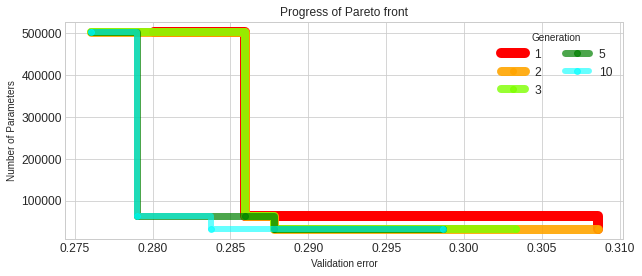

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import matplotlib.transforms as mtrans

x_list = []
y_list = []

# 출력하고 싶은 generation을 추가합니다. 
# 예를 들어 generation 1,2,3,5,10을 출력하고 싶다면 pareto_list = [1,2,3,5,10]으로 설정합니다.
pareto_list=[1,2,3,5,10]
for i in pareto_list:
  pf_copy = np.load('/content/drive/My Drive/SBSE/pareto_front/pf_g'+str(i)+'.npy')
  pf_copy = pf_copy.tolist()

  pareto_front = set()

  x = []
  y = []

  for pf in pf_copy:
    _, num, val = pf
    x.append(float(val))
    y.append(int(num))

  x_list.append(x)
  y_list.append(y)

color = ['red', 'orange', 'chartreuse', 'green', 'cyan', 'purple', 'magenta', 'brown']
mlp.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,4))

for gen, (x, y) in enumerate(zip(x_list, y_list)):
  x.sort()
  y.sort(reverse=True)
  label = str(pareto_list[gen])
  lw=10-gen*1
  ls=['-','--','-.',':'][gen%4]
  ax.plot(x,y, marker='o',label=label, drawstyle='steps-post', color=color[gen%8], linewidth = lw, alpha=1-gen*0.1)
  #ax.plot(x, y, marker='o', linestyle='', label=label)


ax.legend(loc='best')

plt.legend(title='Generation',prop={'size': 12}, ncol=2)
plt.title('Progress of Pareto front')
plt.xlabel('Validation error',fontsize=10)
plt.ylabel('Number of Parameters',fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
fig.savefig('/content/drive/My Drive/SBSE/pareto_front(1).svg', format='svg')

#Reference
[1] Efficient Multi-objective Neural Architecture Search via Lamarckian Evolution, Thomas Elsken et al. (ICLR 2019)

[2] Fashion-MNIST dataset (https://github.com/zalandoresearch/fashion-mnist)